Baseline_TF
https://www.kaggle.com/code/ivaneleskin/baseline-tf

In [2]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import json
import gc
from sklearn.model_selection import train_test_split
# import missingno as msno

from pathlib import Path

In [3]:
DATA_ROOT = Path('data')
DF_TRAIN = DATA_ROOT / 'train.csv'
train = pd.read_csv(DF_TRAIN)

print("train.shape = {} rows, {} cols".format(*train.shape))
train.info()
train.head()


train.shape = 94477 rows, 4 cols
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [4]:
class CFG:
    data_path = "data/"
    quick_experiment = False
    is_training = True
    use_aggregation_dataset = True
    num_classes = 250
    rows_per_frame = 543 

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

In [5]:
train = pd.read_csv(f"{CFG.data_path}train.csv")
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = {label_index[key]: key for key in label_index}
train["label"] = train["sign"].map(lambda sign: label_index[sign])

In [6]:
x_filename = 'X_3d_mean.npy'
y_filename = 'y_mean.npy'
if CFG.is_training:
    print('True')
    try:
        X=  np.load(x_filename)
        y= np.load(y_filename)
    except:
        print('True')
        xs, ys = [], []
        num_frames = np.zeros(len(train))
        for i in tqdm(range(len(train))):
            path = f"{CFG.data_path}{train.iloc[i].path}"
            data = load_relevant_data_subset_with_imputation(path)
            ## Mean Aggregation
            xs.append(np.mean(data, axis=0))
            ys.append(train.iloc[i].label)
            num_frames[i] = data.shape[0]
            if CFG.quick_experiment and i == 4999:
                break
        ## Save number of frames of each training sample for data analysis
        train["num_frames"] = num_frames
        X, y = np.array(xs), np.array(ys)
        print(train["num_frames"].describe())
        train.to_csv("train.csv", index=False)
        np.save(x_filename, X)
        np.save(y_filename, y)

    print(X.shape, y.shape)

True
(94477, 543, 3) (94477,)


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(512, return_sequences=True, input_shape=[None,3]),
    tf.keras.layers.GRU(512),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation="softmax"),
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer='adam',
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-05-acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-acc"),
    ]
)

2023-03-04 16:46:34.309304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 16:46:34.325276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 16:46:34.325923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 16:46:34.327147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [47]:
if True:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)
    
    # Double the training data by mirroring the coordinates over the x-axis
    X_train_mirrored = X_train.copy()
    X_train_mirrored[:,:,0] *= -1 # flip over x-axis to mirror the data
    y_train = np.concatenate((y_train, y_train))
    X_train = np.concatenate((X_train, X_train_mirrored))

    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint("model.h5"),
        tf.keras.callbacks.EarlyStopping(
            # monitor='val_accuracy',
            monitor='val_loss',
            patience=6,
            restore_best_weights=True,
        ),
    ]
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=128, callbacks=callbacks)    
else:
    model = tf.keras.models.load_model("../model.h5")
model.summary()

(75581, 543, 3) (75581,) (18896, 543, 3) (18896,)
Epoch 1/10
591/591 [==============================] - 89s 147ms/step - loss: 5.4825 - accuracy: 0.0053 - top-05-acc: 0.0241 - top-10-acc: 0.0480 - val_loss: 5.3776 - val_accuracy: 0.0062 - val_top-05-acc: 0.0315 - val_top-10-acc: 0.0619
Epoch 2/10
591/591 [==============================] - 88s 149ms/step - loss: 5.3594 - accuracy: 0.0067 - top-05-acc: 0.0328 - top-10-acc: 0.0662 - val_loss: 5.2669 - val_accuracy: 0.0101 - val_top-05-acc: 0.0450 - val_top-10-acc: 0.0851
Epoch 3/10
591/591 [==============================] - 90s 152ms/step - loss: 5.1822 - accuracy: 0.0127 - top-05-acc: 0.0592 - top-10-acc: 0.1103 - val_loss: 5.0304 - val_accuracy: 0.0185 - val_top-05-acc: 0.0819 - val_top-10-acc: 0.1471
Epoch 4/10
591/591 [==============================] - 90s 153ms/step - loss: 4.9739 - accuracy: 0.0216 - top-05-acc: 0.0970 - top-10-acc: 0.1714 - val_loss: 4.8230 - val_accuracy: 0.0327 - val_top-05-acc: 0.1310 - val_top-10-acc: 0.2207
Ep

In [48]:
import matplotlib.pyplot as plt
import numpy as np

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'top-05-acc', 'top-10-acc', 'val_loss', 'val_accuracy', 'val_top-05-acc', 'val_top-10-acc'])


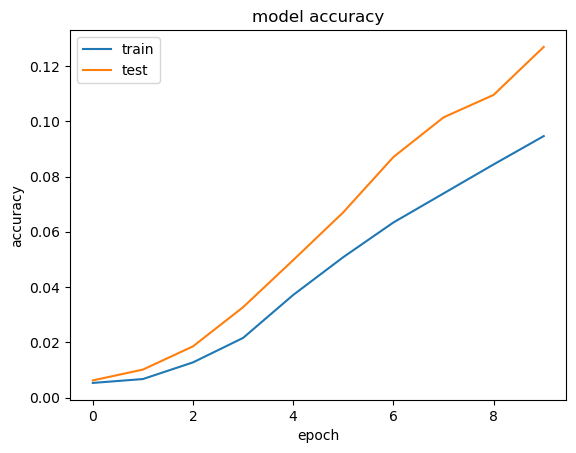

In [49]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

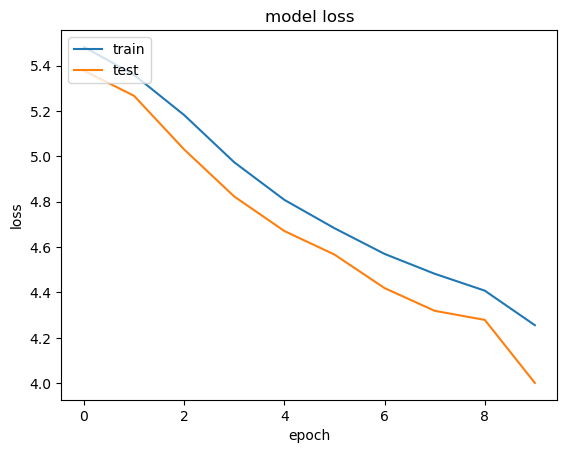

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
def get_model():
    return model

In [16]:
get_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 512)         794112    
                                                                 
 gru_1 (GRU)                 (None, 512)               1575936   
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)              

In [17]:
inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
x = tf.reduce_mean(x, axis=0, keepdims=True)

# for i in range(1, len(model.layers)):
x = model.layers[0](x)
x = model.layers[1](x)
x = model.layers[2](x)

In [18]:
def get_inference_model(model):
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
    x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
    x = tf.reduce_mean(x, axis=0, keepdims=True)
    
    for i in range(0, len(model.layers)):
        x = model.layers[i](x)
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(x)
    inference_model = tf.keras.Model(inputs=inputs, outputs=output) 
    inference_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    return inference_model

In [19]:
inference_model = get_inference_model(model)
inference_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.math.is_nan_1 (TFOpLambda)  (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.zeros_like_1 (TFOpLambda)   (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.where_1 (TFOpLambda)        (None, 543, 3)       0           ['tf.math.is_nan_1[0][0]',       
                                                                  'tf.zeros_like_1[0][0]',    

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"
# Save the model.
with open(model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpia00ff5a/assets


INFO:tensorflow:Assets written to: /tmp/tmpia00ff5a/assets
2023-03-04 12:02:50.521843: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-04 12:02:50.521868: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-04 12:02:50.522325: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpia00ff5a
2023-03-04 12:02:50.530728: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-04 12:02:50.530753: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpia00ff5a
2023-03-04 12:02:50.570877: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-03-04 12:02:50.598252: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-04 12:02:50.672304: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [21]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")
corr = 0
wrong = []
for i in tqdm(range(100)):
    frames = load_relevant_data_subset(f'../{train.iloc[i].path}')
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])
    if index_label[sign] == train.iloc[i].sign:
        corr += 1
    else:
        wrong.append((index_label[sign], train.iloc[i].sign, train.iloc[i].path))

    #     print(f"Predicted label: {index_label[sign]}, Actual Label: {train.iloc[i].sign}")


    total = i

  0%|                                             | 0/100 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../train_landmark_files/26734/1000035562.parquet'

In [ ]:
r = f'''
{total=}
{corr=}\t Percent: {corr/total:%}
'''
print(r)

In [ ]:
wrongs = pd.DataFrame(data=wrong, columns=['pred','true','path'])
wrongs.groupby('pred').count().reset_index().sort_values('true')